<a href="https://colab.research.google.com/github/iyngaranedu/api-response/blob/develop/Model_improvements_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps



1.   Download the lesion-diagnosis Dataset and unzip it.
2.   Remove unnecessary files and folders and prepare a clean datasets for train and test.
3.   Visualize the images
4.   Building a convolutional neural network
     1.   Preprocess / normalize the images 
     2.   Load all the images
     3.   Build a CNN to find patterns in the images
     4.   Compile our CNN
     5.   Fit the CNN to our training data
     6.   Visualise the training results
     7.   Recreate the model again and compile it and train






# Step 1: Download the lesion-diagnosis Dataset and unzip it.

In [4]:

import zipfile

!wget  https://testing.idev55.com/lesion-diagnosis-images.zip

# Unzip the downloaded file
zip_file = zipfile.ZipFile("lesion-diagnosis-images.zip", "r")
zip_file.extractall()
zip_file.close()

--2022-09-27 20:32:07--  https://testing.idev55.com/lesion-diagnosis-images.zip
Resolving testing.idev55.com (testing.idev55.com)... 3.84.41.34
Connecting to testing.idev55.com (testing.idev55.com)|3.84.41.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2529414732 (2.4G) [application/zip]
Saving to: ‘lesion-diagnosis-images.zip’

lesion-diagnosis-im 100%[===================>]   2.36G   241MB/s    in 9.6s    

2022-09-27 20:32:17 (252 MB/s) - ‘lesion-diagnosis-images.zip’ saved [2529414732/2529414732]



# 2.   Remove unnecessary files and folders and prepare a clean datasets for train and test.

In [5]:
import os
import pathlib
import numpy as np

!mv 'Lesion diagnosis' lesion-diagnosis
!mv lesion-diagnosis/images/train/'actinic keratosis' lesion-diagnosis/images/train/actinic-keratosis
!mv lesion-diagnosis/images/train/'pigmented benign keratosis' lesion-diagnosis/images/train/pigmented-benign-keratosis
!mv lesion-diagnosis/images/train/'basal cell carcinoma' lesion-diagnosis/images/train/basal-cell-carcinoma
!mv lesion-diagnosis/images/train/'seborrheic keratosis' lesion-diagnosis/images/train/seborrheic-keratosis

!mv lesion-diagnosis/images/test/'actinic keratosis' lesion-diagnosis/images/test/actinic-keratosis
!mv lesion-diagnosis/images/test/'pigmented benign keratosis' lesion-diagnosis/images/test/pigmented-benign-keratosis
!mv lesion-diagnosis/images/test/'basal cell carcinoma' lesion-diagnosis/images/test/basal-cell-carcinoma
!mv lesion-diagnosis/images/test/'seborrheic keratosis' lesion-diagnosis/images/test/seborrheic-keratosis

!rm -f lesion-diagnosis/images/train/actinic-keratosis/metadata.csv
!rm -f lesion-diagnosis/images/train/melanoma/metadata.csv
!rm -f lesion-diagnosis/images/train/pigmented-benign-keratosis/metadata.csv
!rm -f lesion-diagnosis/images/train/basal-cell-carcinoma/metadata.csv
!rm -f lesion-diagnosis/images/train/nevus/metadata.csv
!rm -f lesion-diagnosis/images/train/seborrheic-keratosis/metadata.csv

!rm -f lesion-diagnosis/images/test/actinic-keratosis/metadata.csv
!rm -f lesion-diagnosis/images/test/melanoma/metadata.csv
!rm -f lesion-diagnosis/images/test/pigmented-benign-keratosis/metadata.csv
!rm -f lesion-diagnosis/images/test/basal-cell-carcinoma/metadata.csv
!rm -f lesion-diagnosis/images/test/nevus/metadata.csv
!rm -f lesion-diagnosis/images/test/seborrheic-keratosis/metadata.csv


# Walk through the lesion-diagnosis directory and remove .DS_Store file from all the folders
for dirpath in os.walk("lesion-diagnosis"):
  file_path = dirpath[0] + "/.DS_Store"
  if os.path.isfile(file_path):
    os.remove(file_path)


!rm -rf lesion-diagnosis/images/all-images
!cp -R lesion-diagnosis/images lesion-diagnosis/all-images
!mv lesion-diagnosis/all-images lesion-diagnosis/all-lesion-diagnosis-images

In [6]:
# turn our training path into a Python path and created a list of class_names from the subdirectories
data_dir = pathlib.Path("lesion-diagnosis/images/train/") 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['actinic-keratosis' 'basal-cell-carcinoma' 'melanoma' 'nevus'
 'pigmented-benign-keratosis' 'seborrheic-keratosis']


In [7]:
!ls lesion-diagnosis/images/train/

actinic-keratosis     melanoma	pigmented-benign-keratosis
basal-cell-carcinoma  nevus	seborrheic-keratosis


In [8]:
# Setup the train and test directories
data_dir_train = pathlib.Path("lesion-diagnosis/images/train/")
data_dir_test = pathlib.Path("lesion-diagnosis/images/test/")

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.JPG')))
image_count_test = len(list(data_dir_test.glob('*/*.JPG')))
image_count_train, image_count_test

(4790, 1120)

#3. Visualize the images

In [10]:
# A resuable function to view an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img


Image shape: (1936, 2592, 3)


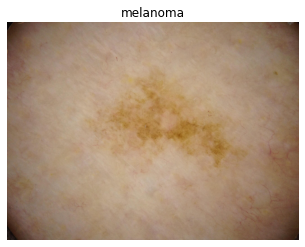

In [11]:
# View a random image from the training dataset
img = view_random_image(target_dir="lesion-diagnosis/images/train/",
                        target_class="melanoma")

In [12]:
img.shape

(1936, 2592, 3)

#4.   Building a convolutional neural network



#### 4.1 Preprocess / normalize the images

In [13]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

In [14]:
import tensorflow as tf

## create train dataset

## get all the train images and resizing them to the size of img_height*img_width and create batches
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),  
    batch_size=batch_size)

Found 4790 files belonging to 6 classes.
Using 3832 files for training.


In [15]:
## create validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),  
    batch_size=batch_size)

Found 4790 files belonging to 6 classes.
Using 958 files for validation.


In [16]:
# List out all the classes of skin lesions and store them in a list. 
# We can get the class names by using the class_names attribute on these datasets. 
class_names = train_dataset.class_names
class_names

['actinic-keratosis',
 'basal-cell-carcinoma',
 'melanoma',
 'nevus',
 'pigmented-benign-keratosis',
 'seborrheic-keratosis']

#### 4.2 Load all the images - Randomly select an image from each classes and display them.

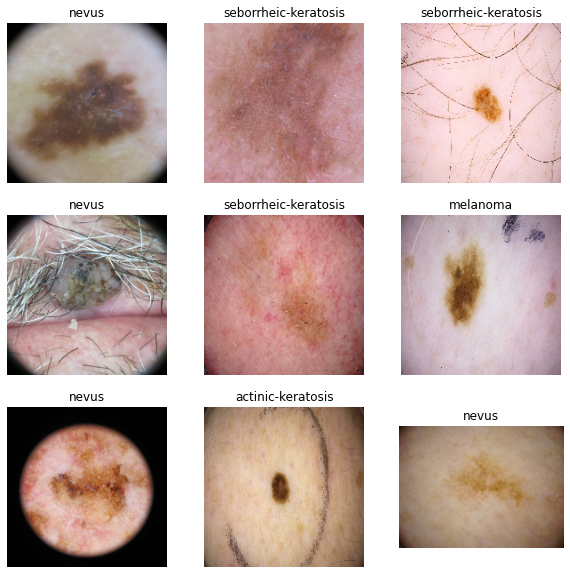

In [93]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis("off")

Keeps the images in memory using `Dataset.cache()` -  after images are loaded off disk during the first epoch.

Overlaps data preprocessing and model execution while training - `Dataset.prefetch().`

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

#### 4.3 Build a CNN to find patterns in the images

In [19]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### 4.4 Compile our CNN

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

#### 4.5 Fit the CNN to our training data

In [22]:
epochs = 20
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/20
120/120 [==============================] - 61s 117ms/step - loss: 1.5128 - accuracy: 0.3867 - val_loss: 1.3092 - val_accuracy: 0.4854
Epoch 2/20
120/120 [==============================] - 3s 24ms/step - loss: 1.2926 - accuracy: 0.4898 - val_loss: 1.2728 - val_accuracy: 0.5115
Epoch 3/20
120/120 [==============================] - 3s 23ms/step - loss: 1.1689 - accuracy: 0.5454 - val_loss: 1.1648 - val_accuracy: 0.5574
Epoch 4/20
120/120 [==============================] - 3s 23ms/step - loss: 1.1011 - accuracy: 0.5725 - val_loss: 1.1129 - val_accuracy: 0.5804
Epoch 5/20
120/120 [==============================] - 3s 23ms/step - loss: 1.0170 - accuracy: 0.6023 - val_loss: 1.1566 - val_accuracy: 0.5564
Epoch 6/20
120/120 [==============================] - 3s 25ms/step - loss: 0.9572 - accuracy: 0.6253 - val_loss: 1.0800 - val_accuracy: 0.5929
Epoch 7/20
120/120 [==============================] - 3s 24ms/step - loss: 0.8691 - accuracy: 0.6641 - val_loss: 1.0281 - val_accuracy: 0.60

#### 4.6 Visualizing training results

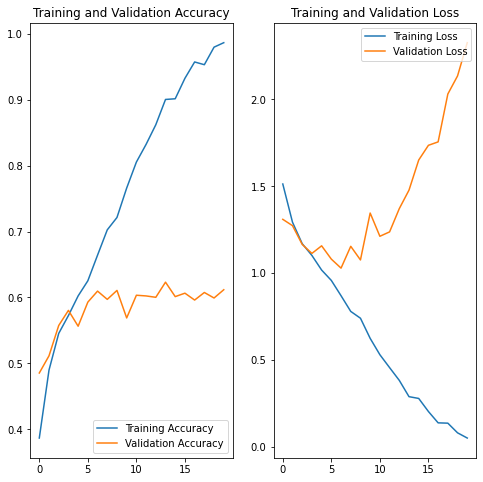

In [23]:
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see here that the training accuracy has improved a lot however, the validation accuracy hasn’t improve much. It means the model is overfitting and it is not able to generalise well.

Similarly, the training loss is falling down and validation loss is increasing dramatically.

To overcome this problem, I am going to use augmentation technique. I am going to generate new samples by modifying the existing training data and use them tp train the model.


In [26]:
data_augmentation = keras.Sequential([
      layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
      layers.experimental.preprocessing.RandomRotation(0.1),
      layers.experimental.preprocessing.RandomZoom(0.1),
])

**Visualise the new created images by augmentation**

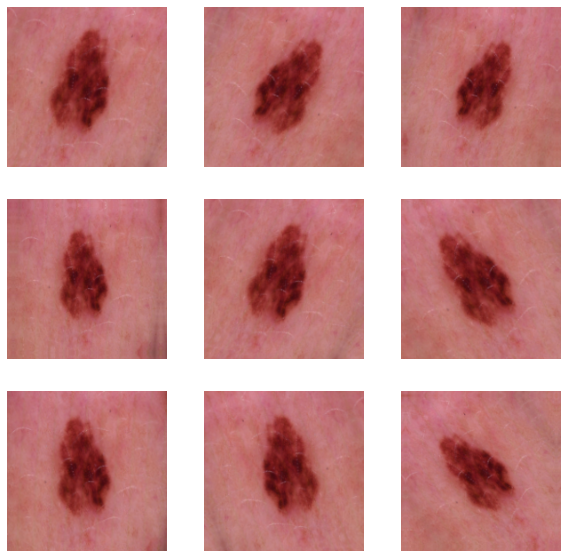

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### 4.7 Recreate the model again and compile it and train

**Create the model**

In [32]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compiling the model**

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Training the model**

In [34]:
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/20
120/120 [==============================] - 4s 28ms/step - loss: 1.6931 - accuracy: 0.3014 - val_loss: 1.4841 - val_accuracy: 0.3894
Epoch 2/20
120/120 [==============================] - 3s 27ms/step - loss: 1.3861 - accuracy: 0.4515 - val_loss: 1.3570 - val_accuracy: 0.4405
Epoch 3/20
120/120 [==============================] - 3s 27ms/step - loss: 1.3156 - accuracy: 0.4736 - val_loss: 1.2298 - val_accuracy: 0.5010
Epoch 4/20
120/120 [==============================] - 3s 26ms/step - loss: 1.2296 - accuracy: 0.5162 - val_loss: 1.2131 - val_accuracy: 0.5198
Epoch 5/20
120/120 [==============================] - 3s 26ms/step - loss: 1.2187 - accuracy: 0.5170 - val_loss: 1.3001 - val_accuracy: 0.4927
Epoch 6/20
120/120 [==============================] - 3s 27ms/step - loss: 1.1912 - accuracy: 0.5344 - val_loss: 1.1562 - val_accuracy: 0.5710
Epoch 7/20
120/120 [==============================] - 3s 27ms/step - loss: 1.1631 - accuracy: 0.5391 - val_loss: 1.1799 - val_accuracy: 0.5564

**Visualizing the results**

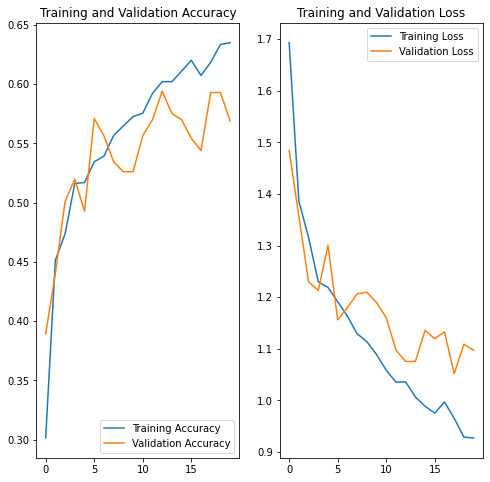

In [35]:
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Here, now we can see some improvement on the model. It's not over-fitting. However, there are some rooms for some more improvements because the accuracy is not very good. 

In order to improve, first I need to ckeck and make sure that data is well-balanced  

In [36]:
from glob import glob
path_list = [ x for x in glob(os.path.join(data_dir_train, '*', '*.JPG')) ] 
lesion_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.JPG')) ]
print(len(lesion_list))

4790


In [38]:
df_dict_original = dict(zip(path_list, lesion_list))
list(df_dict_original.items())[:2]

[('lesion-diagnosis/images/train/pigmented-benign-keratosis/ISIC_0031591.JPG',
  'pigmented-benign-keratosis'),
 ('lesion-diagnosis/images/train/pigmented-benign-keratosis/ISIC_0029776.JPG',
  'pigmented-benign-keratosis')]

In [40]:
import pandas as pd
original_df = pd.DataFrame(list(df_dict_original.items()), columns=['Path','Label'])
original_df.head()

,Path,Label
0,lesion-diagnosis/images/train/pigmented-benign...,pigmented-benign-keratosis
1,lesion-diagnosis/images/train/pigmented-benign...,pigmented-benign-keratosis
2,lesion-diagnosis/images/train/pigmented-benign...,pigmented-benign-keratosis
3,lesion-diagnosis/images/train/pigmented-benign...,pigmented-benign-keratosis
4,lesion-diagnosis/images/train/pigmented-benign...,pigmented-benign-keratosis


In [41]:
original_df[['Label']].value_counts()

Label                     
basal-cell-carcinoma          800
melanoma                      800
nevus                         800
pigmented-benign-keratosis    800
seborrheic-keratosis          800
actinic-keratosis             790
dtype: int64

In [42]:
original_df[['Label']].value_counts(normalize=True)

Label                     
basal-cell-carcinoma          0.167015
melanoma                      0.167015
nevus                         0.167015
pigmented-benign-keratosis    0.167015
seborrheic-keratosis          0.167015
actinic-keratosis             0.164927
dtype: float64

Here, We can see that all the lables has same amount(800) of data except actinic-keratosis. However the actinic-keratosis also has 790 records. The 10 record difference will not be a problem for ML model. So this cannot be the reason not getting a good accuracy value. 

In order to improve the accuracy, I am going to create more samples and try again.

In [43]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 1000 samples per class.

Initialised with 790 image(s) found.
Output directory set to lesion-diagnosis/images/train/actinic-keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x1024 at 0x7FD3D5F3B710>: 100%|██████████| 1000/1000 [02:02<00:00,  8.16 Samples/s]


Initialised with 800 image(s) found.
Output directory set to lesion-diagnosis/images/train/basal-cell-carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024 at 0x7FD450487D90>: 100%|██████████| 1000/1000 [01:43<00:00,  9.67 Samples/s]


Initialised with 800 image(s) found.
Output directory set to lesion-diagnosis/images/train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x7FD4672ECD50>: 100%|██████████| 1000/1000 [10:15<00:00,  1.63 Samples/s]


Initialised with 800 image(s) found.
Output directory set to lesion-diagnosis/images/train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=5184x3456 at 0x7FD4671B0250>: 100%|██████████| 1000/1000 [13:54<00:00,  1.20 Samples/s]


Initialised with 800 image(s) found.
Output directory set to lesion-diagnosis/images/train/pigmented-benign-keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD3D4F0A650>: 100%|██████████| 1000/1000 [00:33<00:00, 30.09 Samples/s]


Initialised with 800 image(s) found.
Output directory set to lesion-diagnosis/images/train/seborrheic-keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x1024 at 0x7FD45046B810>: 100%|██████████| 1000/1000 [04:22<00:00,  3.81 Samples/s]


In [46]:
total_train_images = len(list(data_dir_train.glob('*/output/*.JPG')))
print(total_train_images)

6000


**Let's see the distribution of augmented data.**

In [47]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.JPG'))]
path_list_new[:2]

['lesion-diagnosis/images/train/pigmented-benign-keratosis/output/pigmented-benign-keratosis_original_ISIC_0029559.JPG_5c2654b5-b2f8-4f5e-b7fc-f3e0bc7c67f2.JPG',
 'lesion-diagnosis/images/train/pigmented-benign-keratosis/output/pigmented-benign-keratosis_original_ISIC_0032876.JPG_fa5353f6-aa5a-4b02-8542-1f8e0d5ebc35.JPG']

In [50]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.JPG'))]
lesion_list_new[:2]

['pigmented-benign-keratosis', 'pigmented-benign-keratosis']

In [55]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

df_2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df_2)
new_df.shape

(10790, 2)

In [56]:
new_df.head()

,Path,Label
0,lesion-diagnosis/images/train/pigmented-benign...,pigmented-benign-keratosis
1,lesion-diagnosis/images/train/pigmented-benign...,pigmented-benign-keratosis
2,lesion-diagnosis/images/train/pigmented-benign...,pigmented-benign-keratosis
3,lesion-diagnosis/images/train/pigmented-benign...,pigmented-benign-keratosis
4,lesion-diagnosis/images/train/pigmented-benign...,pigmented-benign-keratosis


In [57]:
# Checking the class distribution after adding the new images
new_df['Label'].value_counts(normalize=True)

pigmented-benign-keratosis    0.166821
basal-cell-carcinoma          0.166821
seborrheic-keratosis          0.166821
nevus                         0.166821
melanoma                      0.166821
actinic-keratosis             0.165894
Name: Label, dtype: float64

In [58]:
new_df['Label'].value_counts()

pigmented-benign-keratosis    1800
basal-cell-carcinoma          1800
seborrheic-keratosis          1800
nevus                         1800
melanoma                      1800
actinic-keratosis             1790
Name: Label, dtype: int64

**Again : Train the model with complete dataset (including newly created images using Augmentor)**

**Create a training dataset**

In [66]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10790 files belonging to 6 classes.
Using 8632 files for training.


**Create a validation dataset**

In [62]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10790 files belonging to 6 classes.
Using 2158 files for validation.


**Recreate the model again**

In [63]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compile the model**

In [64]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Train the model again with epochs - 30**

In [69]:
epochs = 30

history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/30
270/270 [==============================] - 108s 389ms/step - loss: 1.4704 - accuracy: 0.4070 - val_loss: 1.3679 - val_accuracy: 0.4486
Epoch 2/30
270/270 [==============================] - 108s 388ms/step - loss: 1.2661 - accuracy: 0.5039 - val_loss: 1.2264 - val_accuracy: 0.5158
Epoch 3/30
270/270 [==============================] - 105s 376ms/step - loss: 1.1732 - accuracy: 0.5380 - val_loss: 1.1754 - val_accuracy: 0.5366
Epoch 4/30
270/270 [==============================] - 103s 372ms/step - loss: 1.1323 - accuracy: 0.5578 - val_loss: 1.0652 - val_accuracy: 0.5941
Epoch 5/30
270/270 [==============================] - 104s 375ms/step - loss: 1.0643 - accuracy: 0.5894 - val_loss: 1.0976 - val_accuracy: 0.5653
Epoch 6/30
270/270 [==============================] - 104s 374ms/step - loss: 1.0152 - accuracy: 0.6013 - val_loss: 1.0178 - val_accuracy: 0.6047
Epoch 7/30
270/270 [==============================] - 103s 372ms/step - loss: 0.9944 - accuracy: 0.6161 - val_loss: 0.9740 -

**Visualize the model results**

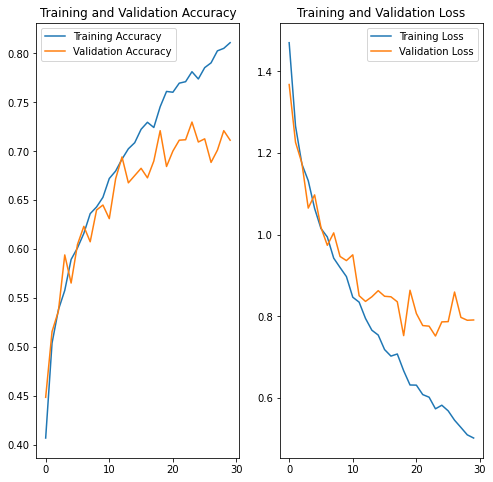

In [70]:
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Making a prediction with our trained model

In [71]:
print(class_names)

['actinic-keratosis', 'basal-cell-carcinoma', 'melanoma', 'nevus', 'pigmented-benign-keratosis', 'seborrheic-keratosis']


--2022-09-27 23:32:07--  https://goldencoastdermatology.com/wp-content/uploads/2020/02/ACTINIC-KERATOSES.jpg
Resolving goldencoastdermatology.com (goldencoastdermatology.com)... 194.1.147.40, 194.1.147.56
Connecting to goldencoastdermatology.com (goldencoastdermatology.com)|194.1.147.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43058 (42K) [image/jpeg]
Saving to: ‘ACTINIC-KERATOSES.jpg’

ACTINIC-KERATOSES.j 100%[===================>]  42.05K  --.-KB/s    in 0.009s  

2022-09-27 23:32:07 (4.80 MB/s) - ‘ACTINIC-KERATOSES.jpg’ saved [43058/43058]



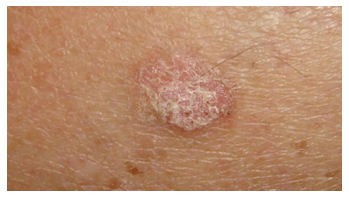

In [94]:
!wget https://goldencoastdermatology.com/wp-content/uploads/2020/02/ACTINIC-KERATOSES.jpg
actinic_keratosis = mpimg.imread("ACTINIC-KERATOSES.jpg")
plt.imshow(actinic_keratosis)
plt.axis(False);

In [95]:
actinic_keratosis.shape

(261, 474, 3)

In [82]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=180):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [96]:
# Load in and preprocess our custom image
actinic_keratosis = load_and_prep_image("ACTINIC-KERATOSES.jpg")
actinic_keratosis

<tf.Tensor: shape=(180, 180, 3), dtype=float32, numpy=
array([[[0.732384  , 0.542384  , 0.39424673],
        [0.6818628 , 0.4777549 , 0.33442155],
        [0.658701  , 0.43367648, 0.28612745],
        ...,
        [0.79636467, 0.6453352 , 0.52722245],
        [0.7537747 , 0.587098  , 0.46544114],
        [0.7535209 , 0.57633305, 0.43436715]],

       [[0.7102745 , 0.50890195, 0.3585098 ],
        [0.73567647, 0.5282255 , 0.37959805],
        [0.67696077, 0.46095586, 0.3081209 ],
        ...,
        [0.8915127 , 0.76515645, 0.66710913],
        [0.791265  , 0.6472453 , 0.54195106],
        [0.76442003, 0.61216027, 0.48933172]],

       [[0.6685131 , 0.4626634 , 0.30995098],
        [0.7285784 , 0.5168137 , 0.36779413],
        [0.71593136, 0.5045343 , 0.35490197],
        ...,
        [0.9801487 , 0.86842483, 0.7829264 ],
        [0.8377212 , 0.70747596, 0.6119856 ],
        [0.79355407, 0.6562992 , 0.54407686]],

       ...,

       [[0.57634807, 0.37901145, 0.2339134 ],
        [0.57

In [97]:
# Add an extra axis
print(f"Shape before new dimension: {actinic_keratosis.shape}")
actinic_keratosis = tf.expand_dims(actinic_keratosis, axis=0) # add an extra dimension at axis 0
print(f"Shape after new dimension: {actinic_keratosis.shape}")
actinic_keratosis

Shape before new dimension: (180, 180, 3)
Shape after new dimension: (1, 180, 180, 3)


<tf.Tensor: shape=(1, 180, 180, 3), dtype=float32, numpy=
array([[[[0.732384  , 0.542384  , 0.39424673],
         [0.6818628 , 0.4777549 , 0.33442155],
         [0.658701  , 0.43367648, 0.28612745],
         ...,
         [0.79636467, 0.6453352 , 0.52722245],
         [0.7537747 , 0.587098  , 0.46544114],
         [0.7535209 , 0.57633305, 0.43436715]],

        [[0.7102745 , 0.50890195, 0.3585098 ],
         [0.73567647, 0.5282255 , 0.37959805],
         [0.67696077, 0.46095586, 0.3081209 ],
         ...,
         [0.8915127 , 0.76515645, 0.66710913],
         [0.791265  , 0.6472453 , 0.54195106],
         [0.76442003, 0.61216027, 0.48933172]],

        [[0.6685131 , 0.4626634 , 0.30995098],
         [0.7285784 , 0.5168137 , 0.36779413],
         [0.71593136, 0.5045343 , 0.35490197],
         ...,
         [0.9801487 , 0.86842483, 0.7829264 ],
         [0.8377212 , 0.70747596, 0.6119856 ],
         [0.79355407, 0.6562992 , 0.54407686]],

        ...,

        [[0.57634807, 0.37901145, 

In [98]:
pred = model.predict(actinic_keratosis)
pred

array([[  5.1310115,   5.7972255,   2.1500115,  -6.9755583,  -6.059508 ,
          4.5621405, -17.167248 , -18.08688  , -14.895285 ]],
      dtype=float32)

In [99]:
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'seborrheic-keratosis'

In [90]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

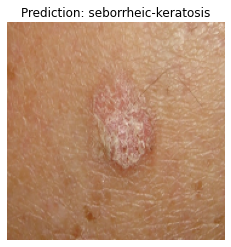

In [100]:
# Test our model on a custom image
pred_and_plot(model, "ACTINIC-KERATOSES.jpg", class_names)